In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
# To load the environment variable defined in the .env file
from dotenv import load_dotenv
load_dotenv();

In [47]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mtick

from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

import src.features.build_features as FeaturesManager

In [59]:
seasons_year = [2016, 2017, 2018, 2019]
season_type = "Regular"
features_data = FeaturesManager.build_features(seasons_year, season_type)

# We take the absolute value, for symmetry reasons
features_data['Shot angle'] = features_data['Shot angle'].abs()
features_data.sample(10)

,Game ID,Event Index,Period,Team,Type,Shot Type,Shooter,Goalie,Strength,X,...,Last event Y,Last event elapsed time,Last event distance,st_X,st_Y,Shot distance,Shot angle,Is Goal,Is Empty,Game seconds
11809,2017020190,125,2,Florida Panthers (FLA),SHOT,Slap Shot,Jonathan Huberdeau,Sergei Bobrovsky,NaN,67.0,...,-34.0,8,146.109548,67.0,14.0,26.076810,32.471192,0,0,78
50560,2019020828,61,1,Montréal Canadiens (MTL),SHOT,Wrist Shot,Marco Scandella,John Gibson,NaN,64.0,...,-1.0,9,24.351591,-64.0,24.0,154.870914,8.914927,0,0,753
43644,2016020720,195,2,Buffalo Sabres (BUF),SHOT,Backhand,Brian Gionta,Juuse Saros,NaN,85.0,...,-27.0,3,23.000000,85.0,-4.0,5.656854,45.000000,0,0,774
45069,2017020723,296,3,Vancouver Canucks (VAN),SHOT,Wrist Shot,Loui Eriksson,Connor Hellebuyck,NaN,69.0,...,-22.0,20,32.000000,69.0,10.0,22.360680,26.565051,0,0,926
32710,2018020531,313,3,Florida Panthers (FLA),SHOT,Snap Shot,Evgenii Dadonov,Frederik Andersen,NaN,35.0,...,0.0,15,39.357337,35.0,-18.0,56.920998,18.434949,0,0,934
5158,2016020086,131,2,Pittsburgh Penguins (PIT),SHOT,Backhand,Sidney Crosby,James Reimer,NaN,-77.0,...,-22.0,24,31.048349,77.0,-8.0,14.422205,33.690068,0,0,555
10022,2017020161,247,3,Arizona Coyotes (ARI),SHOT,Snap Shot,Zac Rinaldo,Cory Schneider,NaN,-67.0,...,-22.0,37,136.718689,67.0,8.0,23.409400,19.983107,0,0,368
58208,2017020933,304,3,New York Rangers (NYR),SHOT,Slap Shot,Tony DeAngelo,Antti Niemi,NaN,62.0,...,27.0,23,34.234486,62.0,-7.0,27.892651,14.534455,0,0,729
32263,2018020524,235,3,Edmonton Oilers (EDM),SHOT,Wrist Shot,Ty Rattie,Jake Allen,NaN,83.0,...,2.0,9,43.011626,83.0,3.0,6.708204,26.565051,0,0,47
68597,2018021121,283,3,San Jose Sharks (SJS),SHOT,Wrist Shot,Gustav Nyquist,Malcolm Subban,NaN,75.0,...,18.0,24,20.880613,75.0,12.0,18.439089,40.601295,0,0,746


In [60]:
distance_data = features_data[['Shot distance', 'Is Goal']].dropna()
X = distance_data['Shot distance'].to_numpy().reshape(-1, 1)
y = distance_data['Is Goal'].to_numpy().reshape(-1, 1)

In [61]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

In [63]:
accuracy = clf.score(X_valid, y_valid)
print(f'Accuracy on validation set = {np.around(100.*accuracy, 2)}%')

Accuracy on validation set = 90.75%


0.9075036897893466
Dumb Accuracy on validation set = 90.75%


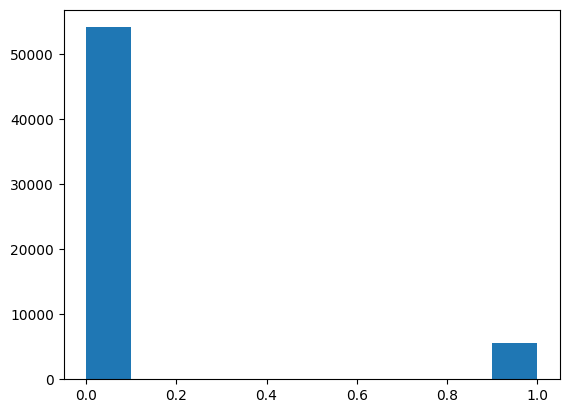

In [64]:
# Accuracy is not the right metric to use, as the classes are unbalanced
num_goals = (y_valid==1).sum()
num_no_goals = (y_valid==0).sum()
print(num_no_goals / (num_no_goals+num_goals))
plt.hist(y_valid);

# A dumb model that predicts 0 (no goals) all the time reach the same level of performance
def dumb_model(X, y):
    pred = np.zeros_like(X)
    return (y == pred).mean()


dumb_accuracy = dumb_model(X_valid, y_valid)
print(f'Dumb Accuracy on validation set = {np.around(100.*dumb_accuracy, 2)}%')

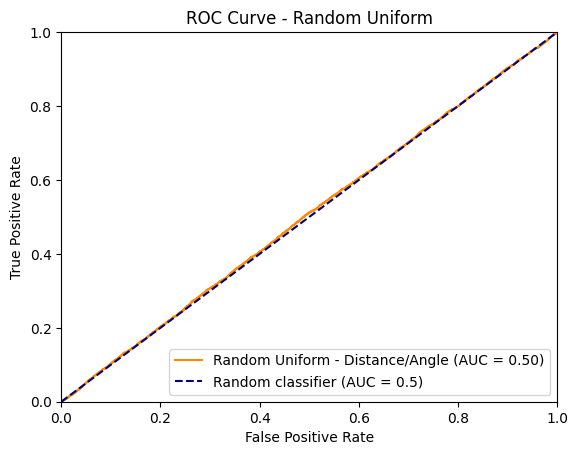

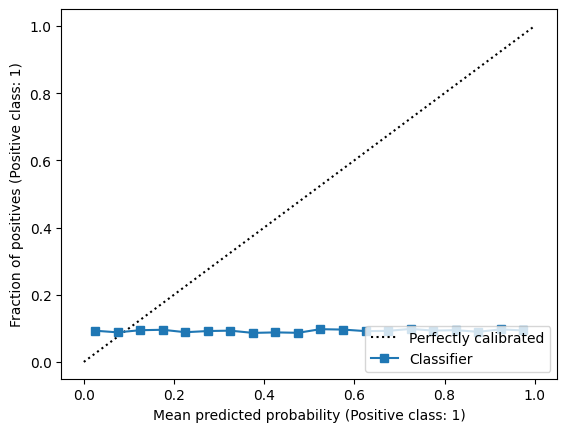

In [65]:
distance_angle_data = features_data[['Shot distance', 'Shot angle', 'Is Goal']].dropna()
X = distance_angle_data[['Shot distance', 'Shot angle']].to_numpy()
y = distance_angle_data['Is Goal'].to_numpy().reshape(-1, 1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


y_proba = np.random.uniform(low=0.0, high=1.0, size=len(y_valid))
y_proba_no_goals = y_proba
y_proba_goals = 1 - y_proba

fpr, tpr, _ = roc_curve(y_valid, y_proba_goals)
roc_auc = auc(fpr, tpr)
fpr, tpr, _ = roc_curve(y_valid.ravel(), y_proba_goals.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", label="Random Uniform - Distance/Angle (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", label='Random classifier (AUC = 0.5)', linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Uniform")
plt.legend(loc="lower right")
plt.show()

disp = CalibrationDisplay.from_predictions(y_valid, y_proba_goals, n_bins=20)

In [66]:
# print(y_valid)
# print(y_proba_goals)

ind = (y_proba_goals > 0.2) * (y_proba_goals <= 0.6)
print((y_valid[ind] == 1).sum())
print((y_valid[ind] == 0).sum())

print( (y_valid[ind] == 1).sum() / (y_valid[ind] == 0).sum() )

2166
21619
0.10018964799481937


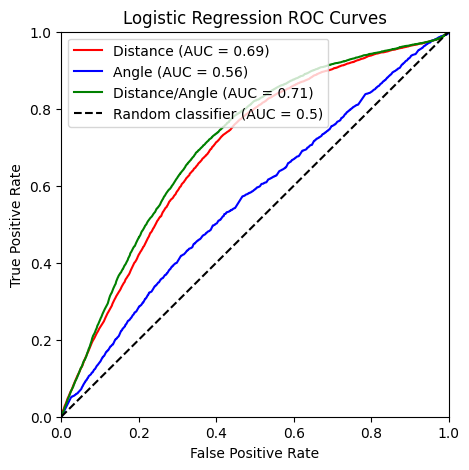

In [67]:
distance_data = features_data[['Shot distance', 'Shot angle', 'Is Goal']].dropna()
X = distance_data[['Shot distance', 'Shot angle']].to_numpy().reshape(-1, 2)
y = distance_data['Is Goal'].to_numpy().reshape(-1, 1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression - Distance only
X_distance_train, X_distance_valid = X_train[:,0].reshape(-1, 1), X_valid[:,0].reshape(-1, 1)
clf_distance = LogisticRegression(random_state=0).fit(X_distance_train, y_train)

y_proba_goals_distance = clf_distance.predict_proba(X_distance_valid)[:,1]
fpr_distance, tpr_distance, _ = roc_curve(y_valid.ravel(), y_proba_goals_distance.ravel())
roc_auc_distance = auc(fpr_distance, tpr_distance)

# Logistic Regression - Angle only
X_angle_train, X_angle_valid = X_train[:,1].reshape(-1, 1), X_valid[:,1].reshape(-1, 1)
clf_angle = LogisticRegression(random_state=0).fit(X_angle_train, y_train)

y_proba_goals_angle  = clf_angle.predict_proba(X_angle_valid)[:,1]
fpr_angle, tpr_angle, _ = roc_curve(y_valid.ravel(), y_proba_goals_angle.ravel())
roc_auc_angle = auc(fpr_angle, tpr_angle)

# Logistic Regression - Distance and Angle
X_distance_angle_train, X_distance_angle_valid = X_train, X_valid
clf_distance_angle = LogisticRegression(random_state=0).fit(X_distance_angle_train, y_train)

y_proba_goals_distance_angle  = clf_distance_angle.predict_proba(X_distance_angle_valid)[:,1]
fpr_distance_angle, tpr_distance_angle, _ = roc_curve(y_valid.ravel(), y_proba_goals_distance_angle.ravel())
roc_auc_distance_angle = auc(fpr_distance_angle, tpr_distance_angle)

# Random classifier
y_proba_goals_random = np.random.uniform(low=0.0, high=1.0, size=len(y_valid))

plt.figure(figsize=(5, 5))
plt.plot(fpr_distance, tpr_distance, color="red", label="Distance (AUC = %0.2f)" % roc_auc_distance)
plt.plot(fpr_angle, tpr_angle, color="blue", label="Angle (AUC = %0.2f)" % roc_auc_angle)
plt.plot(fpr_distance_angle, tpr_distance_angle, color="green", label="Distance/Angle (AUC = %0.2f)" % roc_auc_distance_angle)
plt.plot([0, 1], [0, 1], color="black", label='Random classifier (AUC = 0.5)', linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression ROC Curves")
plt.legend(loc="upper left")
plt.show()


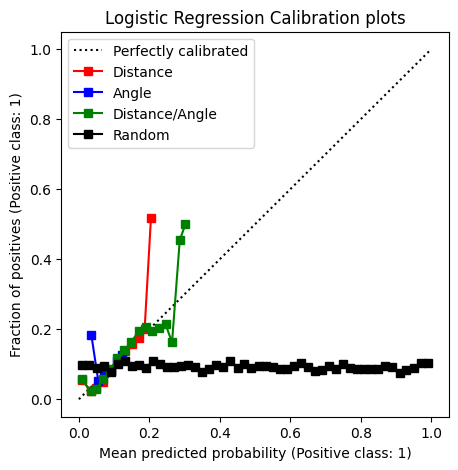

In [68]:

fig = plt.figure(figsize=(5, 5))
gs = GridSpec(2, 2)
ax_calibration_curve = fig.add_subplot(gs[:2, :2])
nbins = 50
calibration_displays = {
    CalibrationDisplay.from_predictions(y_valid, y_proba_goals_distance, n_bins=nbins, name='Distance', ax=ax_calibration_curve, color='red'),
    CalibrationDisplay.from_predictions(y_valid, y_proba_goals_angle, n_bins=nbins, name='Angle', ax=ax_calibration_curve, color='blue'),
    CalibrationDisplay.from_predictions(y_valid, y_proba_goals_distance_angle, n_bins=nbins, name='Distance/Angle', ax=ax_calibration_curve, color='green'),
    CalibrationDisplay.from_predictions(y_valid, y_proba_goals_random, n_bins=nbins, name='Random', ax=ax_calibration_curve, color='black')
}
ax_calibration_curve.set_title("Logistic Regression Calibration plots");
plt.legend(loc="upper left")

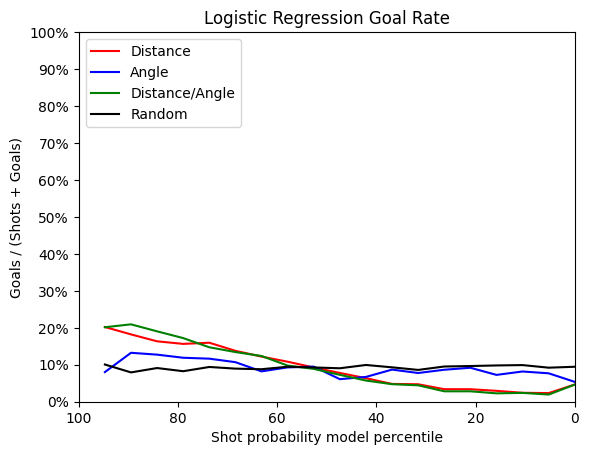

In [69]:
x = np.linspace(0, 100, 20)
percentiles_distance = [np.percentile(y_proba_goals_distance, i) for i in x]
percentiles_angle = [np.percentile(y_proba_goals_angle, i) for i in x]
percentiles_distance_angle = [np.percentile(y_proba_goals_distance_angle, i) for i in x]
percentiles_random = [np.percentile(y_proba_goals_random, i) for i in x]

goals_over_total_distance = []
goals_over_total_angle = []
goals_over_total_distance_angle = []
goals_over_total_random = []

for count_p, _ in enumerate(x[:-1]):

    ind = (y_proba_goals_distance >= percentiles_distance[count_p]) & (y_proba_goals_distance < percentiles_distance[count_p+1])
    num_goals = (y_valid[ind] == 1).sum()
    num_no_goals = (y_valid[ind] == 0).sum()
    ratio = num_goals / (num_goals + num_no_goals)
    goals_over_total_distance.append(100.*ratio)

    ind = (y_proba_goals_angle >= percentiles_angle[count_p]) & (y_proba_goals_angle < percentiles_angle[count_p+1])
    num_goals = (y_valid[ind] == 1).sum()
    num_no_goals = (y_valid[ind] == 0).sum()
    ratio = num_goals / (num_goals + num_no_goals)
    goals_over_total_angle.append(100.*ratio)

    ind = (y_proba_goals_distance_angle >= percentiles_distance_angle[count_p]) & (y_proba_goals_distance_angle < percentiles_distance_angle[count_p+1])
    num_goals = (y_valid[ind] == 1).sum()
    num_no_goals = (y_valid[ind] == 0).sum()
    ratio = num_goals / (num_goals + num_no_goals)
    goals_over_total_distance_angle.append(100.*ratio)

    ind = (y_proba_goals_random >= percentiles_random[count_p]) & (y_proba_goals_random < percentiles_random[count_p+1])
    num_goals = (y_valid[ind] == 1).sum()
    num_no_goals = (y_valid[ind] == 0).sum()
    ratio = num_goals / (num_goals + num_no_goals)
    goals_over_total_random.append(100.*ratio)

goals_over_total_distance = np.array(goals_over_total_distance)
goals_over_total_angle = np.array(goals_over_total_angle)
goals_over_total_distance_angle = np.array(goals_over_total_distance_angle)
goals_over_total_random = np.array(goals_over_total_random)

X = x[0:-1]
Y1 = goals_over_total_distance
Y2 = goals_over_total_angle
Y3 = goals_over_total_distance_angle
Y4 = goals_over_total_random

fig = plt.figure()

ax = fig.add_subplot(1,1,1)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.plot(X, Y1, color='red', label='Distance')
plt.plot(X, Y2, color='blue', label='Angle')
plt.plot(X, Y3, color='green', label='Distance/Angle')
plt.plot(X, Y4, color='black', label='Random')
plt.title('Logistic Regression Goal Rate')
plt.xlabel('Shot probability model percentile')
plt.ylabel('Goals / (Shots + Goals)')
plt.xlim([100.0, 0.0])
plt.ylim([0.0, 100.0])
plt.yticks(range(0, 110, 10))
plt.legend(loc="upper left");
plt.show()


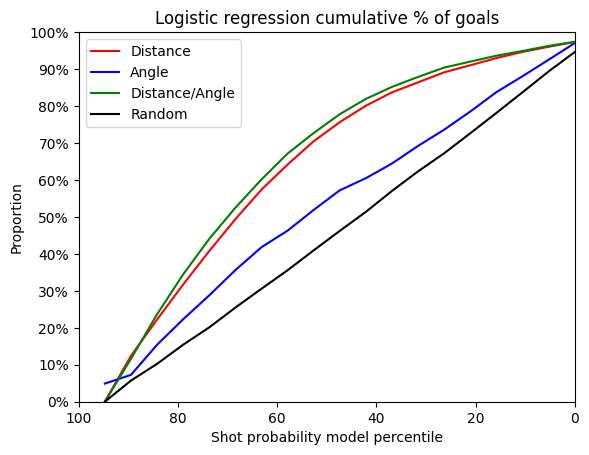

In [70]:
goals_ratio_distance = []
goals_ratio_angle = []
goals_ratio_distance_angle = []
goals_ratio_random = []

num_total_goals = (y_valid == 1).sum()

for count_p, _ in enumerate(x[:-1]):

    ind = (y_proba_goals_distance >= percentiles_distance[count_p]) & (y_proba_goals_distance < percentiles_distance[count_p+1])
    num_goals = (y_valid[ind] == 1).sum()
    ratio = num_goals / num_total_goals
    goals_ratio_distance.append(100.*ratio)

    ind = (y_proba_goals_angle >= percentiles_angle[count_p]) & (y_proba_goals_angle < percentiles_angle[count_p+1])
    num_goals = (y_valid[ind] == 1).sum()
    ratio = num_goals / num_total_goals
    goals_ratio_angle.append(100.*ratio)

    ind = (y_proba_goals_distance_angle >= percentiles_distance_angle[count_p]) & (y_proba_goals_distance_angle < percentiles_distance_angle[count_p+1])
    num_goals = (y_valid[ind] == 1).sum()
    ratio = num_goals / num_total_goals
    goals_ratio_distance_angle.append(100.*ratio)

    ind = (y_proba_goals_random >= percentiles_random[count_p]) & (y_proba_goals_random < percentiles_random[count_p+1])
    num_goals = (y_valid[ind] == 1).sum()
    ratio = num_goals / num_total_goals
    goals_ratio_random.append(100.*ratio)

X = x[0:-1]
Y1 = 100-np.cumsum(np.array(goals_ratio_distance))
Y2 = 100-np.cumsum(np.array(goals_ratio_angle))
Y3 = 100-np.cumsum(np.array(goals_ratio_distance_angle))
Y4 = 100-np.cumsum(np.array(goals_ratio_random))

fig = plt.figure()

ax = fig.add_subplot(1,1,1)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.plot(X, Y1, color='red', label='Distance')
plt.plot(X, Y2, color='blue', label='Angle')
plt.plot(X, Y3, color='green', label='Distance/Angle')
plt.plot(X, Y4, color='black', label='Random')
plt.title('Logistic regression cumulative % of goals')
plt.xlabel('Shot probability model percentile')
plt.ylabel('Proportion')
plt.xlim([100.0, 0.0])
plt.ylim([0.0, 100.0])
plt.yticks(range(0, 110, 10));
plt.legend(loc="upper left");
plt.show()